In [1]:
# import some basics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Snap files (hdf5)
Alternatively to reading all the text output files, almost all of the data is stored in the `snap.40_[TIME].h5part` files, where the time corresponds to the time in nbody units (not physical units!). Let's have a look at the first snap file `snap.40_0.h5part`.

In [2]:
# library for reading hdf5 in python
import h5py

In [3]:
# open one of the hdf5 files
hdf = h5py.File(("example_1k/snap.40_0.h5part"), 'r')

In [4]:
# show contents
hdf.keys()

<KeysViewHDF5 ['Step#0', 'Step#1', 'Step#10', 'Step#11', 'Step#12', 'Step#13', 'Step#14', 'Step#15', 'Step#16', 'Step#17', 'Step#18', 'Step#19', 'Step#2', 'Step#20', 'Step#21', 'Step#22', 'Step#23', 'Step#24', 'Step#25', 'Step#26', 'Step#27', 'Step#28', 'Step#29', 'Step#3', 'Step#30', 'Step#31', 'Step#32', 'Step#33', 'Step#34', 'Step#35', 'Step#36', 'Step#37', 'Step#38', 'Step#39', 'Step#4', 'Step#40', 'Step#41', 'Step#42', 'Step#43', 'Step#44', 'Step#45', 'Step#46', 'Step#47', 'Step#48', 'Step#49', 'Step#5', 'Step#50', 'Step#51', 'Step#52', 'Step#53', 'Step#54', 'Step#55', 'Step#56', 'Step#57', 'Step#58', 'Step#59', 'Step#6', 'Step#60', 'Step#61', 'Step#62', 'Step#63', 'Step#64', 'Step#7', 'Step#8', 'Step#9']>

Notice that `snap.40_[TIME].h5part` files are again subdivided into multiple steps. Let's have a look at one of the steps contents.

In [5]:
# List step contents
hdf["Step#0"].keys()

<KeysViewHDF5 ['000 Scalars', '001 X1', '002 X2', '003 X3', '004 V1', '005 V2', '006 V3', '007 A1', '008 A2', '009 A3', '010 AD1', '011 AD2', '012 AD3', '013 D21', '014 D22', '015 D23', '016 D31', '017 D32', '018 D33', '019 STEP', '020 STEPR', '021 T0', '022 T0R', '023 M', '024 NB-Sph', '025 POT', '026 R*', '027 L*', '028 Teff*', '029 RC*', '030 MC*', '031 KW', '032 Name', '033 Type']>

These are now the datasets. As you can see this is a lot of data, as usual, consult the [nbody manual](https://github.com/kaiwu-astro/Nbody6PPGPU-beijing/tree/stable/doc), especially the chapter on HDF5 Output aobut more details on the datasets.

Let's take a look at the Luminosity $L_*$ using the `027 L*` dataset

In [6]:
# python style
hdf["Step#0"]["027 L*"]

<HDF5 dataset "027 L*": shape (1000,), type "<f4">

We can see it's a data set now, but we don't see it's content? We'll talk about it later. At least we see 1000 entries, corresponding to each star in the 1k example run.

Instead of pythons list subindexing we can also use unix style paths to similary access the values in the hdf5 data.

In [7]:
# unix path style
hdf["Step#0/027 L*"]

<HDF5 dataset "027 L*": shape (1000,), type "<f4">

Simple trick to see the contents. This is rarely needed, only if you want to take a look at the data

In [ ]:
# show contents
hdf["Step#0/027 L*"][:]

# Energy time evolution (HDF5)
As we can see from the [nbody manual](https://github.com/kaiwu-astro/Nbody6PPGPU-beijing/tree/stable/doc) or from the output above, we can get the potential from `025 POT`. For the kinetic energy we can use `023 M`, `004 V1`, `005 V2`, `006 V3` to do the calculations ourself.

## Getting potential and kinetic energy
First things first, let's do it just for one time step!

In [8]:
# Just sum over all values in the pot dataset
print(f"EPOT",np.sum(hdf["Step#0/025 POT"]))

EPOT -2622.835


For the kinetic energy wee need to calculate the energy for each star first with $E_\mathrm{kin} = \frac{1}{2}mv^2$ using `Step#0/004 V1`, `Step#0/005 V2` and `Step#0/006 V3` for the velocieties and `Step#0/023 M` for the masses. Afterwars all the individual energies can be summed up

In [9]:
# Sum over all individual kinetic energies
EKIN = np.sum(
    # v^2
    np.power(hdf["Step#0/004 V1"], 2) + \
            np.power(hdf["Step#0/005 V2"], 2) + \
            np.power(hdf["Step#0/006 V3"], 2) \
           \
        * 0.5 * hdf["Step#0/023 M"] # 1/2 * M
)

print(f"EKIN",EKIN)

EKIN 917.64856


That looks okay! Let's go and extract more steps and more files!
We'll use the `glob` libarary to automatically detect all the files for us

## Getting time evolution of energy

In [10]:
import glob

In [11]:
# show first 5 found files
glob.glob("example_1k/snap.40_*")[:5]

['example_1k/snap.40_12.h5part',
 'example_1k/snap.40_0.h5part',
 'example_1k/snap.40_1.h5part',
 'example_1k/snap.40_10.h5part',
 'example_1k/snap.40_11.h5part']

glob seems to find the files, (note that this purposly shows only the first 5 found files!). But hey? these file seem to be in an almost random order? Don't worry, later on we'll sort the data by time, leave it as it is for now.

In [12]:
# initialize dataframe
df = pd.DataFrame(columns=["EPOT","EKIN"])
df

,EPOT,EKIN


The `df` DataFrame is empty for now, so let's fill it with some values!

In [13]:
# work through all the snap files
for snap_file in glob.glob("example_1k/snap.40_*"):
    hdf = h5py.File(("example_1k/snap.40_0.h5part"), 'r')
    
    # work through all the steps
    for step in hdf.keys():
        # calculate potential
        EPOT = np.sum(hdf[f"{step}/025 POT"])

        # calculate kinetic energy
        EKIN = np.sum(
                        # v^2
                        np.power(hdf[f"{step}/004 V1"], 2) + \
                        np.power(hdf[f"{step}/005 V2"], 2) + \
                        np.power(hdf[f"{step}/006 V3"], 2) \
                        \
                        * 0.5 * hdf[f"{step}/023 M"] # 1/2 * M
                )
        # append data to our pandas DataFrame
        # the hdf[f"{step}/000 Scalars"][0] part
        # set's the index. This corresponds to the time
        # in nbody units
        df.loc[hdf[f"{step}/000 Scalars"][0]] = [EPOT,EKIN]
        
        
        
        
    hdf.close()
df

,EPOT,EKIN
0.000000,-2622.834961,917.648560
0.015625,-1917.351318,929.267456
0.156250,-1612.498291,881.794678
0.171875,-1355.787598,781.491699
0.187500,-1646.364502,942.886719
...,...,...
0.984375,-1115.298340,1008.267517
1.000000,-1437.316284,1193.342773
0.109375,-1420.866211,764.854004
0.125000,-1747.986572,912.352417


Now we've successfully filled our data set! But if we look at the index, it's all messed up. Now's the time to sort it out!

In [14]:
# inplace tells pandas to sort the dataframe directly
# otherwise it would create a sorted copy.
df.sort_index(inplace=True)
df

,EPOT,EKIN
0.000000,-2622.834961,917.648560
0.015625,-1917.351318,929.267456
0.031250,-1896.192871,914.130737
0.046875,-1602.325439,794.078491
0.062500,-1847.723389,911.370056
...,...,...
0.937500,-1396.262939,1142.266113
0.953125,-1133.887451,1014.003540
0.968750,-1296.095215,1083.789673
0.984375,-1115.298340,1008.267517


That looks better, go on plotting!

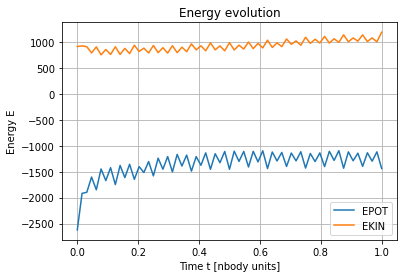

In [15]:
# prepare plot
fig = plt.figure()
ax = fig.gca()

# plot
df.plot(ax=ax)

# make the plot a little bit nicer
ax.set_title(r"Energy evolution")
ax.set_xlabel(r"Time t [nbody units]")
ax.set_ylabel(r"Energy E")
ax.grid()

# Hertzsprung–Russell diagram (HDF5)
From the output of `hdf["Step#[SOME_STEP]].keys()` (or the manual) we see the relevant data can be take directly from `028 Teff*` and `027 L*`

In [16]:
# as we've closed the hdf5 file in the loop above
# we need to open it again
hdf = h5py.File(("example_1k/snap.40_0.h5part"), 'r')

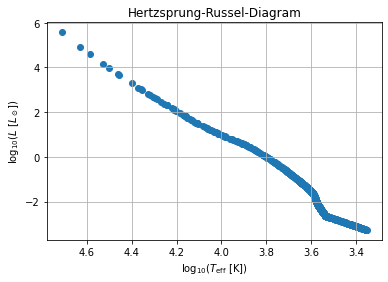

In [17]:
# prepare figure
fig = plt.figure()
ax = fig.gca()

# notice we can directly pass the data, 
# without using the [:] trick to show data.
# Furthermore we'll calculate the log of the
# values instead of setting y- and x-scale to a logscale.
# Technically speaing it doesn't really matter.
ax.scatter(np.log10(hdf["Step#0/028 Teff*"]),
           np.log10(hdf["Step#0/027 L*"]))


ax.set_title("Hertzsprung-Russel-Diagram")
# typical for HRDs
ax.invert_xaxis()

ax.set_xlabel(r"$\mathrm{log}_{10}(T_\mathrm{eff}$ [K])")
ax.set_ylabel(r"$\mathrm{log}_{10}(L$ [$L_\odot]$)")
ax.grid()

## Multiple HRDs

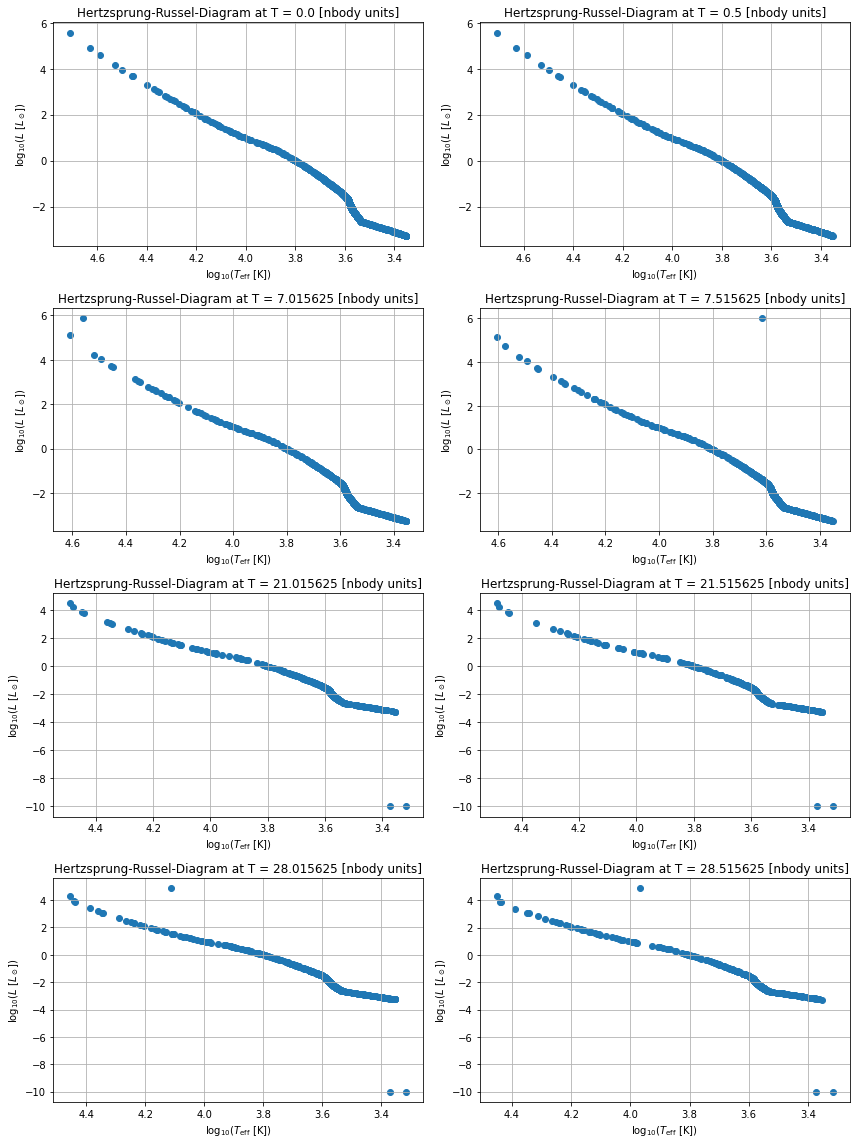

In [18]:
# Select files and steps to plot
SNAP_FILES = [0,7,21,28]
STEPS = [0,32]

# initialize figure
fig = plt.figure(figsize=(6*len(STEPS), 4*len(SNAP_FILES)))

for snap_file in SNAP_FILES:
    # load current file
    hdf = h5py.File((f"example_1k/snap.40_{snap_file}.h5part"), 'r')
    for step in STEPS:
        # ad subplot for current file and step
        ax = fig.add_subplot(len(SNAP_FILES),
                             len(STEPS),
                             (SNAP_FILES.index(snap_file)*len(STEPS)) + STEPS.index(step) + 1)
        # plot current step
        ax.scatter(np.log10(hdf[f"Step#{step}/028 Teff*"]),
                   np.log10(hdf[f"Step#{step}/027 L*"]))
        # get current time for current file and step
        t = hdf[f"Step#{step}/000 Scalars"][0]
        
        # make plot a little bit nicer
        ax.set_title(f"Hertzsprung-Russel-Diagram at T = {t} [nbody units]")
        ax.invert_xaxis()

        ax.set_xlabel(r"$\mathrm{log}_{10}(T_\mathrm{eff}$ [K])")
        ax.set_ylabel(r"$\mathrm{log}_{10}(L$ [$L_\odot]$)")
        ax.grid()
    hdf.close()
        
fig.tight_layout()